In [1]:
!pip install seaborn --upgrade
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm
import math, re, os
import pandas as pd
import numpy as np
import random
import plotly.express as px

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

     |████████████████████████████████| 293 kB 2.1 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


2023-01-08 09:45:12.298754: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-08 09:45:12.298882: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


In [2]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)



Running on TPU  grpc://10.0.0.2:8470


2023-01-08 09:45:17.053468: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-08 09:45:17.056146: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-08 09:45:17.056175: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-08 09:45:17.056202: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4fa75d901e19): /proc/driver/nvidia/version does not exist
2023-01-08 09:45:17.059103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


******loading the dataset ******

this is a kaggle exclusive library

In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

gs://kds-e46cf9604ba9eb344e23f7d9394e7721c23e6e2d058fc48f3020226f


becuase we are running on tpu ,we can use higher quality datasets ,thus we set the image size to 512 in 512

we have already stored the link to the dataset on google,so we grav the 512 in 512 file ,and call in gcs path

num_parallel_reads=AUTO instructs the API to read from multiple files if available. It figures out how many automatically.

In [4]:
IMAGE_SIZE = [512, 512]

GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE 

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 103

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # should be 512 512 3
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed. #See Note 2.3 above 😀

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files. #See Note 2.2 above 😀
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


2023-01-08 09:45:21.930302: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-08 09:45:22.008013: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-08 09:45:22.074896: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


maybe remove count data items

In [5]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO) #tuning4
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [6]:
BATCH_SIZE = 128

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


In [7]:
print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape) #See Note 3.1 above 😀
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [ 13  28  49   4  16  53   4  67  33  96 103  39  29   8  91  51  16 102
  77  47  41  49  13  49   8  88  86  93  67  51  71   0  53  47   8  49
 102   0  68  59   4  73  48  49  67  45  63   4  46  25  21  49  53  71
  91  87  74  72  67  94  83  71  53  87  91  12  49 102  10  67  13 103
  21  13  70  47  83  13  46  48  45  75 103   4  29  95   4   4  74  81
  71  70  79   4  47  94  69  14  67 103  81   4  87  68  67 103 102  67
  73  68  75  67  67  53 102  73  32   0 103  83  74  79  30  39  50  72
  49  31]


2023-01-08 09:45:28.031814: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673171128.028506686","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 1","grpc_status":3}


In [8]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape) #See Note 3.1 above 😀
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['b87e16bc0' 'd8437a7f7' '981396649' '85c2ca274' 'f7019798c' 'b738a5ab0'
 '931b0b249' 'd35565c6c' '6fc119103' '7725cb554' 'f0727012b' '7b53e5791'
 'ce5af8fc3' 'aaab6a867' 'dd9cf65da' '13d3c108e' '34cc8d691' 'e93da9242'
 '46241640f' 'c77e635e6' '0befbdd9e' 'b05b5e5ed' '7484473e0' 'cffa6d1a4'
 'b811b25c9' 'bb15fd515' 'ce1019f58' 'cc0e98f9c' 'd83d3fbab' '1691d45e6'
 '026d4082b' '4fdd76274' 'a2fcedaf7' '62e32ec91' 'ed8c3c3f8' '7dc69b4eb'
 'b7c137651' 'c4d436848' '07ccfbc89' 'a0c7302d1' '1eba038ad' 'a7caedcb0'
 '92673a9aa' '8128b8af9' '8a8eefe09' 'ce6303fec' 'aa560af38' '9ed2586ca'
 'a64d32c6a' 'a10a0b280' '3d95467fe' 'b145790f2' 'e9a2109c0' '7593bf7d9'
 '09adc5faa' '1314201bc' '787578be9' '719a12da9' '4d178a6b4' '47c4e4fce'
 '903a3ee76' '94a7c5ed2' '3c5103dc0' '11db2e1d4' 'e2e81b2c4' 'cfdfb9028'
 '4e7bdb1cb' '8ccdebad5' '440daa96f' '953076db7' '32d710e55' '1a5d9c089'
 '364e07591' 

some methods

In [9]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
        # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 
                                'OK' if correct else 'NO', 
                                u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, display_mismatches_only=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        if display_mismatches_only:
            if predictions[i] != label:
                subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
        else:        
            subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def display_training_curves_v2(training, validation, learning_rate_list, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title, color='b')
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.', 'learning rate'])        
    
    ax2 = ax.twinx()
    ax2.plot(learning_rate_list, 'g-')
    ax2.set_ylabel('learning rate', color='g')

lets print bunch of sample images

In [10]:
ds_iter = iter(ds_train.unbatch().batch(20))

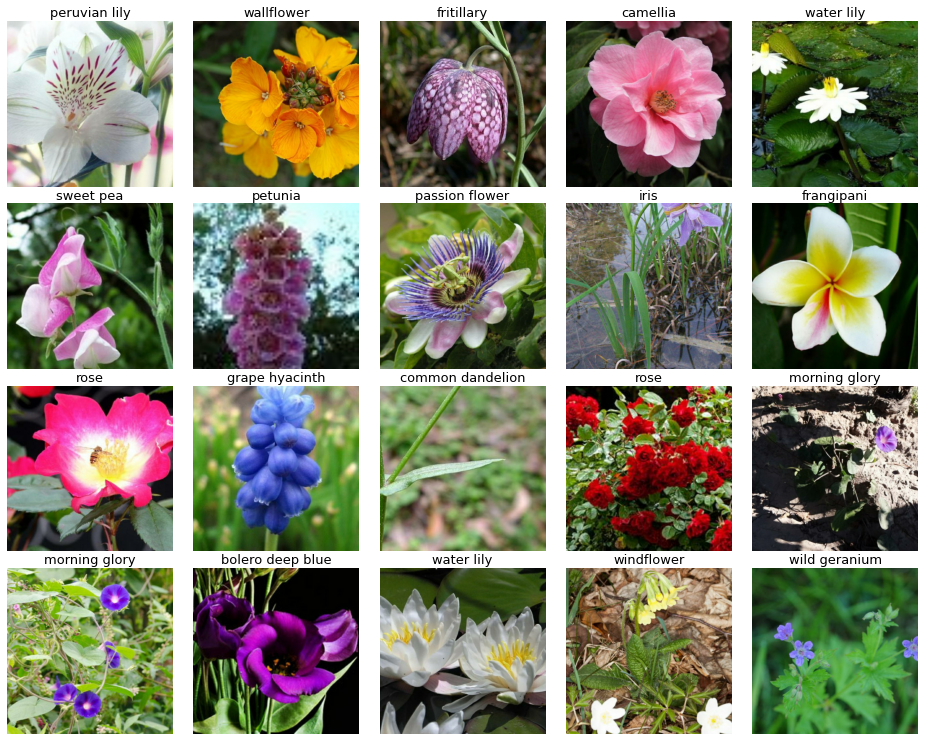

In [11]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

testing the augmentation

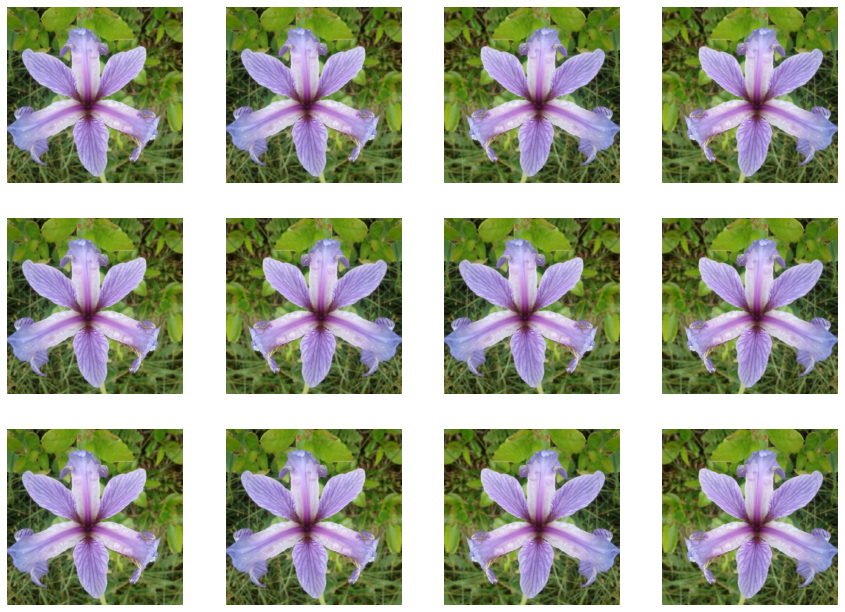

In [12]:
row = 3
col = 4
all_elements = get_training_dataset().unbatch()
one_element = tf.data.Dataset.from_tensors(next(iter(all_elements)))
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

**random earsing data**

In [13]:
#tuning4
SEED = 2020

def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)

    
def data_augment_v2(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    
    flag = random.randint(1,3)
    coef_1 = random.randint(70, 90) * 0.01
    coef_2 = random.randint(70, 90) * 0.01
    
    if flag == 1:
        image = tf.image.random_flip_left_right(image, seed=SEED)
    elif flag == 2:
        image = tf.image.random_flip_up_down(image, seed=SEED)
    else:
        image = tf.image.random_crop(image, [int(IMAGE_SIZE[0]*coef_1), int(IMAGE_SIZE[0]*coef_2), 3],seed=SEED)
        
    image = random_blockout(image)
    
    return image, label 

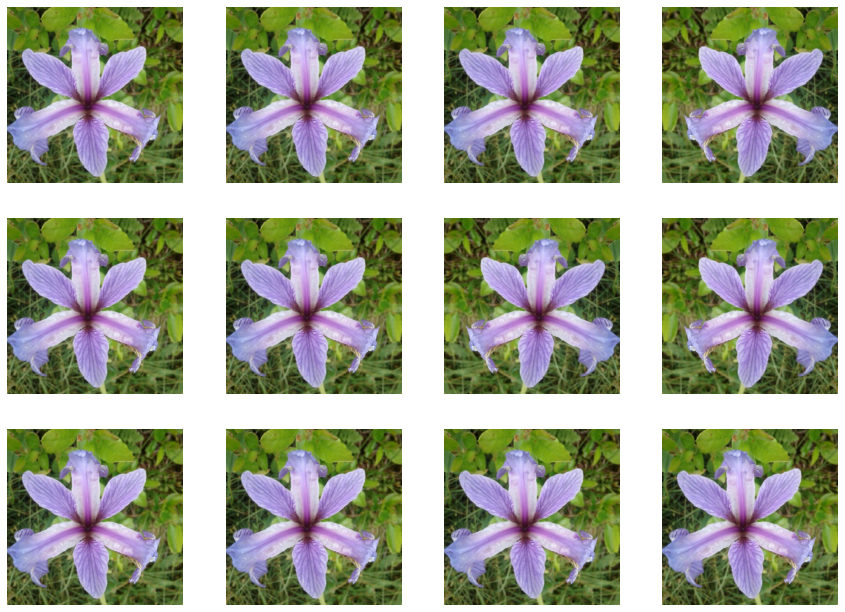

In [14]:
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment_v2).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

next augmentation ,playing with the size,saturation,blur,...

In [15]:
import tensorflow_addons as tfa

# Randomly make some changes to the images and return the new images and labels
def data_augment_v3(image, label):
        
    # Set seed for data augmentation
    seed = 100
    
    # Randomly resize and then crop images
    image = tf.image.resize(image, [720, 720])
    image = tf.image.random_crop(image, [512, 512, 3], seed = seed)

    # Randomly reset brightness of images
    image = tf.image.random_brightness(image, 0.6, seed = seed)
    
    # Randomly reset saturation of images
    image = tf.image.random_saturation(image, 3, 5, seed = seed)
        
    # Randomly reset contrast of images
    image = tf.image.random_contrast(image, 0.3, 0.5, seed = seed)

    # Randomly reset hue of images, but this will make the colors really weird, which we think will not happen
    # in common photography
    # image = tf.image.random_hue(image, 0.5, seed = seed)
    
    # Blur images
    image = tfa.image.mean_filter2d(image, filter_shape = 10)
    
    # Randomly flip images
    image = tf.image.random_flip_left_right(image, seed = seed)
    image = tf.image.random_flip_up_down(image, seed = seed)
    
    # Fail to rotate and transform images due to some bug in TensorFlow
    # angle = random.randint(0, 180)
    # image = tfa.image.rotate(image, tf.constant(np.pi * angle / 180))
    # image = tfa.image.transform(image, [1.0, 1.0, -250, 0.0, 1.0, 0.0, 0.0, 0.0])
    
    return image, label

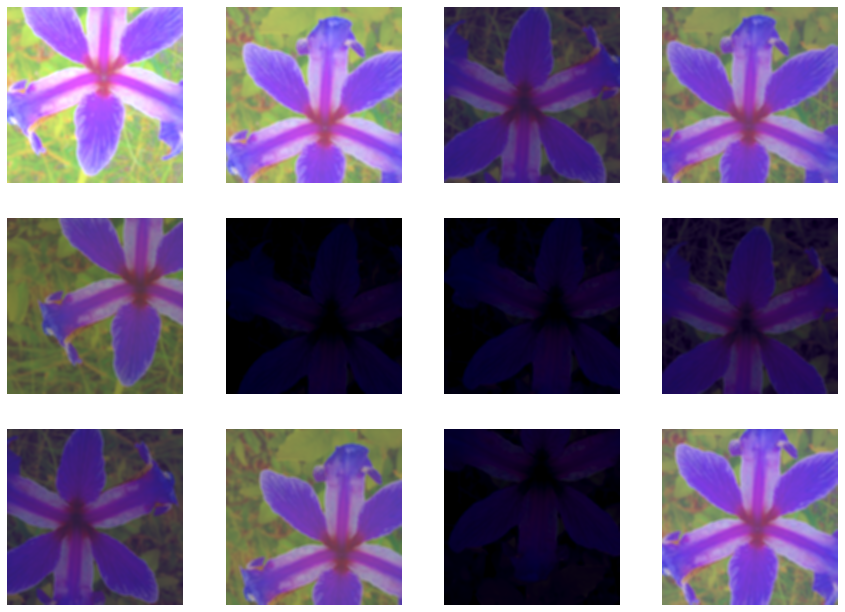

In [16]:
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment_v3).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

define model

erase ->

Step 5: Define Model
Now we're ready to create a neural network for classifying images! We'll use what's known as transfer learning. With transfer learning, you reuse part of a pretrained model to get a head-start on a new dataset.

For this tutorial, we'll to use a model called VGG16 pretrained on ImageNet). Later, you might want to experiment with other models included with Keras. (Xception wouldn't be a bad choice.)

The distribution strategy we created earlier contains a context manager, strategy.scope. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in a strategy.scope() context.

Note 4 😀
Let's transfer learn from different neural network architectures from tf.keras.applications and keep track of their performance
Source: https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/applications
Note that TF 2.4 has many more models available for transfer learning
Source: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [17]:
', '.join(tf.keras.applications.__dir__())

'__name__, __doc__, __package__, __loader__, __spec__, __path__, __file__, __cached__, __builtins__, _sys, densenet, efficientnet, imagenet_utils, inception_resnet_v2, inception_v3, mobilenet, mobilenet_v2, mobilenet_v3, nasnet, resnet, resnet50, resnet_v2, vgg16, vgg19, xception, DenseNet121, DenseNet169, DenseNet201, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, InceptionResNetV2, InceptionV3, MobileNet, MobileNetV2, MobileNetV3Large, MobileNetV3Small, NASNetLarge, NASNetMobile, ResNet101, ResNet152, ResNet50, ResNet101V2, ResNet152V2, ResNet50V2, VGG16, VGG19, Xception'

In [18]:
# Model weights are saved at the end of every epoch, if it's the best seen so far during model.fit
checkpoint_filepath = "Petals_to_the_Metal-70K_images-trainable_True-MobileNetV2.h5" #"Petals_to_the_Metal-70K_images-trainable_True-DenseNet201.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [19]:
# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs. 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

downloading efficent net

turn on if you want to use efficientnet

In [20]:
use_efficientnet = False #tuning9
if use_efficientnet:
    !pip install -q efficientnet
    from efficientnet.tfkeras import EfficientNetB7

deadling with unbalanced data

In [21]:
weight_per_class = True

if weight_per_class:
    from collections import Counter
    import gc

    gc.enable()

    def get_training_dataset_raw():
        dataset = load_dataset(TRAINING_FILENAMES, labeled = True, ordered = False)
        return dataset

    raw_training_dataset = get_training_dataset_raw()

    label_counter = Counter()
    for images, labels in raw_training_dataset:
        label_counter.update([labels.numpy()])

    del raw_training_dataset    

    TARGET_NUM_PER_CLASS = 122 #?

    def get_weight_for_class(class_id):
        counting = label_counter[class_id]
        weight = TARGET_NUM_PER_CLASS / counting
        return weight

    weight_per_class = {class_id: get_weight_for_class(class_id) for class_id in range(104)}

we are using dense net

In [22]:
using_ensemble_models = False

In [23]:
if not using_ensemble_models:
    with strategy.scope():
        #pretrained_model = tf.keras.applications.VGG16
        #pretrained_model = tf.keras.applications.DenseNet201
        #pretrained_model = tf.keras.applications.InceptionResNetV2
        #pretrained_model = tf.keras.applications.InceptionV3
        #pretrained_model = tf.keras.applications.MobileNet
        #pretrained_model = tf.keras.applications.MobileNetV2
        #pretrained_model = tf.keras.applications.NASNetMobile
        #pretrained_model = tf.keras.applications.ResNet50
        #pretrained_model = tf.keras.applications.ResNet101V2
        #pretrained_model = tf.keras.applications.VGG19
        #pretrained_model = tf.keras.applications.Xception
        #pretrained_model = tf.keras.applications.DenseNet201 
        #pretrained_model = EfficientNetB7

        pretrained_model = tf.keras.applications.DenseNet201(
            include_top=False ,
            weights='imagenet', #tuning10 weights='noisy-student' instead of 'imagenet'
                                #Self-training with Noisy Student improves ImageNet classification https://arxiv.org/abs/1911.04252) 
            #pooling='avg', #tuning1
            input_shape=[*IMAGE_SIZE, 3]
        )

        pretrained_model.trainable = True #tuning8 pretrained_model.trainable = True

        model = tf.keras.Sequential([
            pretrained_model, #Base pretrained on ImageNet to extract features from images

            tf.keras.layers.GlobalAveragePooling2D(), ##Attach a new head to act as a classifier
            #tf.keras.layers.Dropout(0.3), #tuning3
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])

74842112/74836368 [==============================] - 1s 0us/step


In [24]:
if not using_ensemble_models:
    model.compile(
        optimizer='nadam', #tuning2 optimizer='nadam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

In [25]:
if not using_ensemble_models:
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


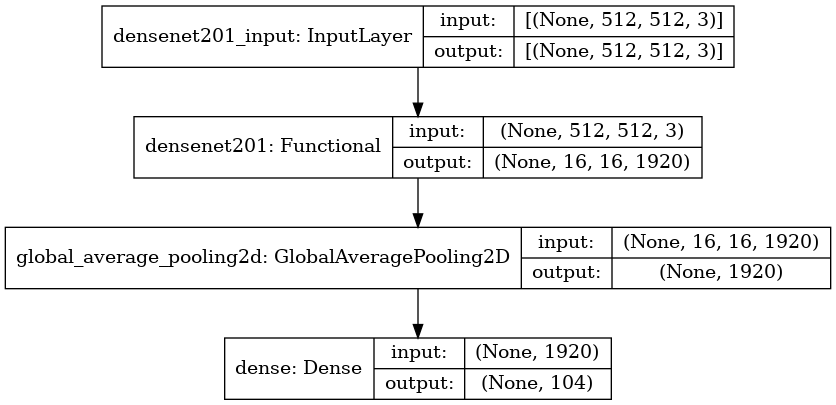

In [26]:
#if not using_ensemble_models:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
if not using_ensemble_models:
    # Define training epochs
    EPOCHS = 10

    # Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync #See Note 3.1 above 😀

    STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

Learning rate schedule: 1e-05 to 0.0004 to 0.000133


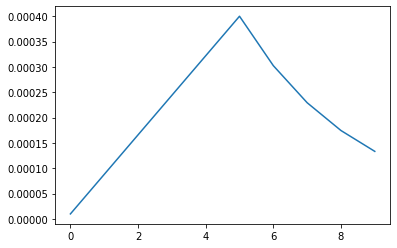

In [28]:
if not using_ensemble_models:
    # Learning Rate Schedule for Fine Tuning #
    def exponential_lr(epoch,
                       start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005 * strategy.num_replicas_in_sync, #tuning1
                       rampup_epochs = 5, sustain_epochs = 0,
                       exp_decay = 0.75): #tuning1

        def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
            # linear increase from start to rampup_epochs
            if epoch < rampup_epochs:
                lr = ((max_lr - start_lr) /
                      rampup_epochs * epoch + start_lr)
            # constant max_lr during sustain_epochs
            elif epoch < rampup_epochs + sustain_epochs:
                lr = max_lr
            # exponential decay towards min_lr
            else:
                lr = ((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                      min_lr)
            return lr
        return lr(epoch,
                  start_lr,
                  min_lr,
                  max_lr,
                  rampup_epochs,
                  sustain_epochs,
                  exp_decay)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

    rng = [i for i in range(EPOCHS)]
    y = [exponential_lr(x) for x in rng]
    plt.plot(rng, y)
    print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
if not using_ensemble_models:
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[lr_callback, checkpoint], # Model weights are saved at the end of every epoch, if it's the best seen so far
        #workers = 3 #tuning5 https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras
        class_weight = weight_per_class #tuning11
    )

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.


In [ ]:
if not using_ensemble_models:
    display_training_curves_v2( 
        history.history['loss'],
        history.history['val_loss'],
        history.history['lr'],
        'loss',
        211,
    )

    display_training_curves_v2(
        history.history['sparse_categorical_accuracy'],
        history.history['val_sparse_categorical_accuracy'],
        history.history['lr'],
        'accuracy',
        212,
    )

In [ ]:
checkpoint_filepath

In [ ]:
if not using_ensemble_models:
    model.load_weights(checkpoint_filepath)

**sadman sakib**

In [ ]:
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [ ]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

In [ ]:
from tensorflow.keras.applications import DenseNet201

def get_model():
    with strategy.scope():
        rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

In [ ]:
def train_cross_validate(folds = 5):
    histories = []
    models = []
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
        print(); print('#'*25)
        print('### FOLD',f+1)
        print('#'*25)
        train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[trn_ind]['TRAINING_FILENAMES']), labeled = True)
        val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES']), labeled = True, ordered = True)
        model = get_model()
        history = model.fit(
            get_training_dataset(train_dataset), 
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = EPOCHS,
            callbacks = [lr_callback],#, early_stopping],
            validation_data = get_validation_dataset(val_dataset),
            verbose=2
        )
        models.append(model)
        histories.append(history)
    return histories, models
histories, models = train_cross_validate(folds = 5)